In [1]:
from sklearn.metrics import pairwise_distances
import pickle
from scipy import sparse

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
nba_stats2021 = pd.read_csv('./nba_stats2021_original.csv')
nba_stats2021.head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%FTA,%OREB,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS
0,Stephen Curry,GSW,33,58,32,26,34.1,31.5,10.3,21.3,...,37.9,8.0,17.9,27.6,29.8,20.8,32.5,12.1,32.1,37.1
1,Bradley Beal,WAS,27,57,29,28,35.6,31.1,11.1,22.8,...,37.0,15.9,14.3,22.9,29.6,20.1,26.5,14.3,32.3,34.9
2,Joel Embiid,PHI,27,47,36,11,31.5,29.1,9.2,18.0,...,58.3,43.3,37.2,18.4,34.7,16.1,35.0,21.5,53.0,37.1
3,Luka Doncic,DAL,22,59,35,24,35.1,28.5,10.1,20.8,...,45.4,12.5,25.6,52.4,49.9,21.3,32.2,16.8,38.5,33.7
4,Damian Lillard,POR,30,61,34,27,35.7,28.4,8.8,20.0,...,43.6,6.0,12.8,46.2,36.6,18.0,29.1,11.5,43.1,32.0


In [3]:
# Creating List of defensive stat features
def_stat = []
for feature in nba_stats2021.columns:
    if feature.startswith(('D','%D','S','%S','B','R','%B')):
        def_stat.append(feature)
print(len(def_stat))
def_stat

15


['DREB_x',
 'REB',
 'STL_x',
 'BLK_x',
 'DD2',
 'DEFRTG',
 'DREB%_x',
 'REB%',
 'DEF\xa0RTG',
 '%DREB_x',
 'STL%',
 '%BLK_x',
 'DEFWS',
 '%STL',
 '%BLKA']

## ```Defining Clusters in Models Defensive Stats```
---

Parameters and Scalers are form the More_Modeling Notebook.

In [7]:
X = nba_stats2021[def_stat]
y = nba_stats2021['Player']

#scale data
nn = Normalizer()
X_nn = nn.fit_transform(X)

#dimensionality reduction
pca = PCA(n_components = 3)
pca.fit(X_nn)
X_pca = pca.transform(X_nn)
print("Cumulative Explained Variance:", pca.explained_variance_ratio_.sum())

#creating clusters
deff = KMeans(n_clusters = 2, random_state= 42)
deff.fit(X_pca)
y_kmeans = deff.predict(X_pca)
nba_stats2021['deff_kmean'] = deff.labels_
deff_sil = silhouette_score(X_nn, deff.labels_)
print("Silhouette Score:", silhouette_score(X_nn, deff.labels_))

Cumulative Explained Variance: 0.8423767400143817
Silhouette Score: 0.361631474645697


In [8]:
deff_cluster0 = nba_stats2021[nba_stats2021['deff_kmean']==0]
deff_cluster1 = nba_stats2021[nba_stats2021['deff_kmean']==1]

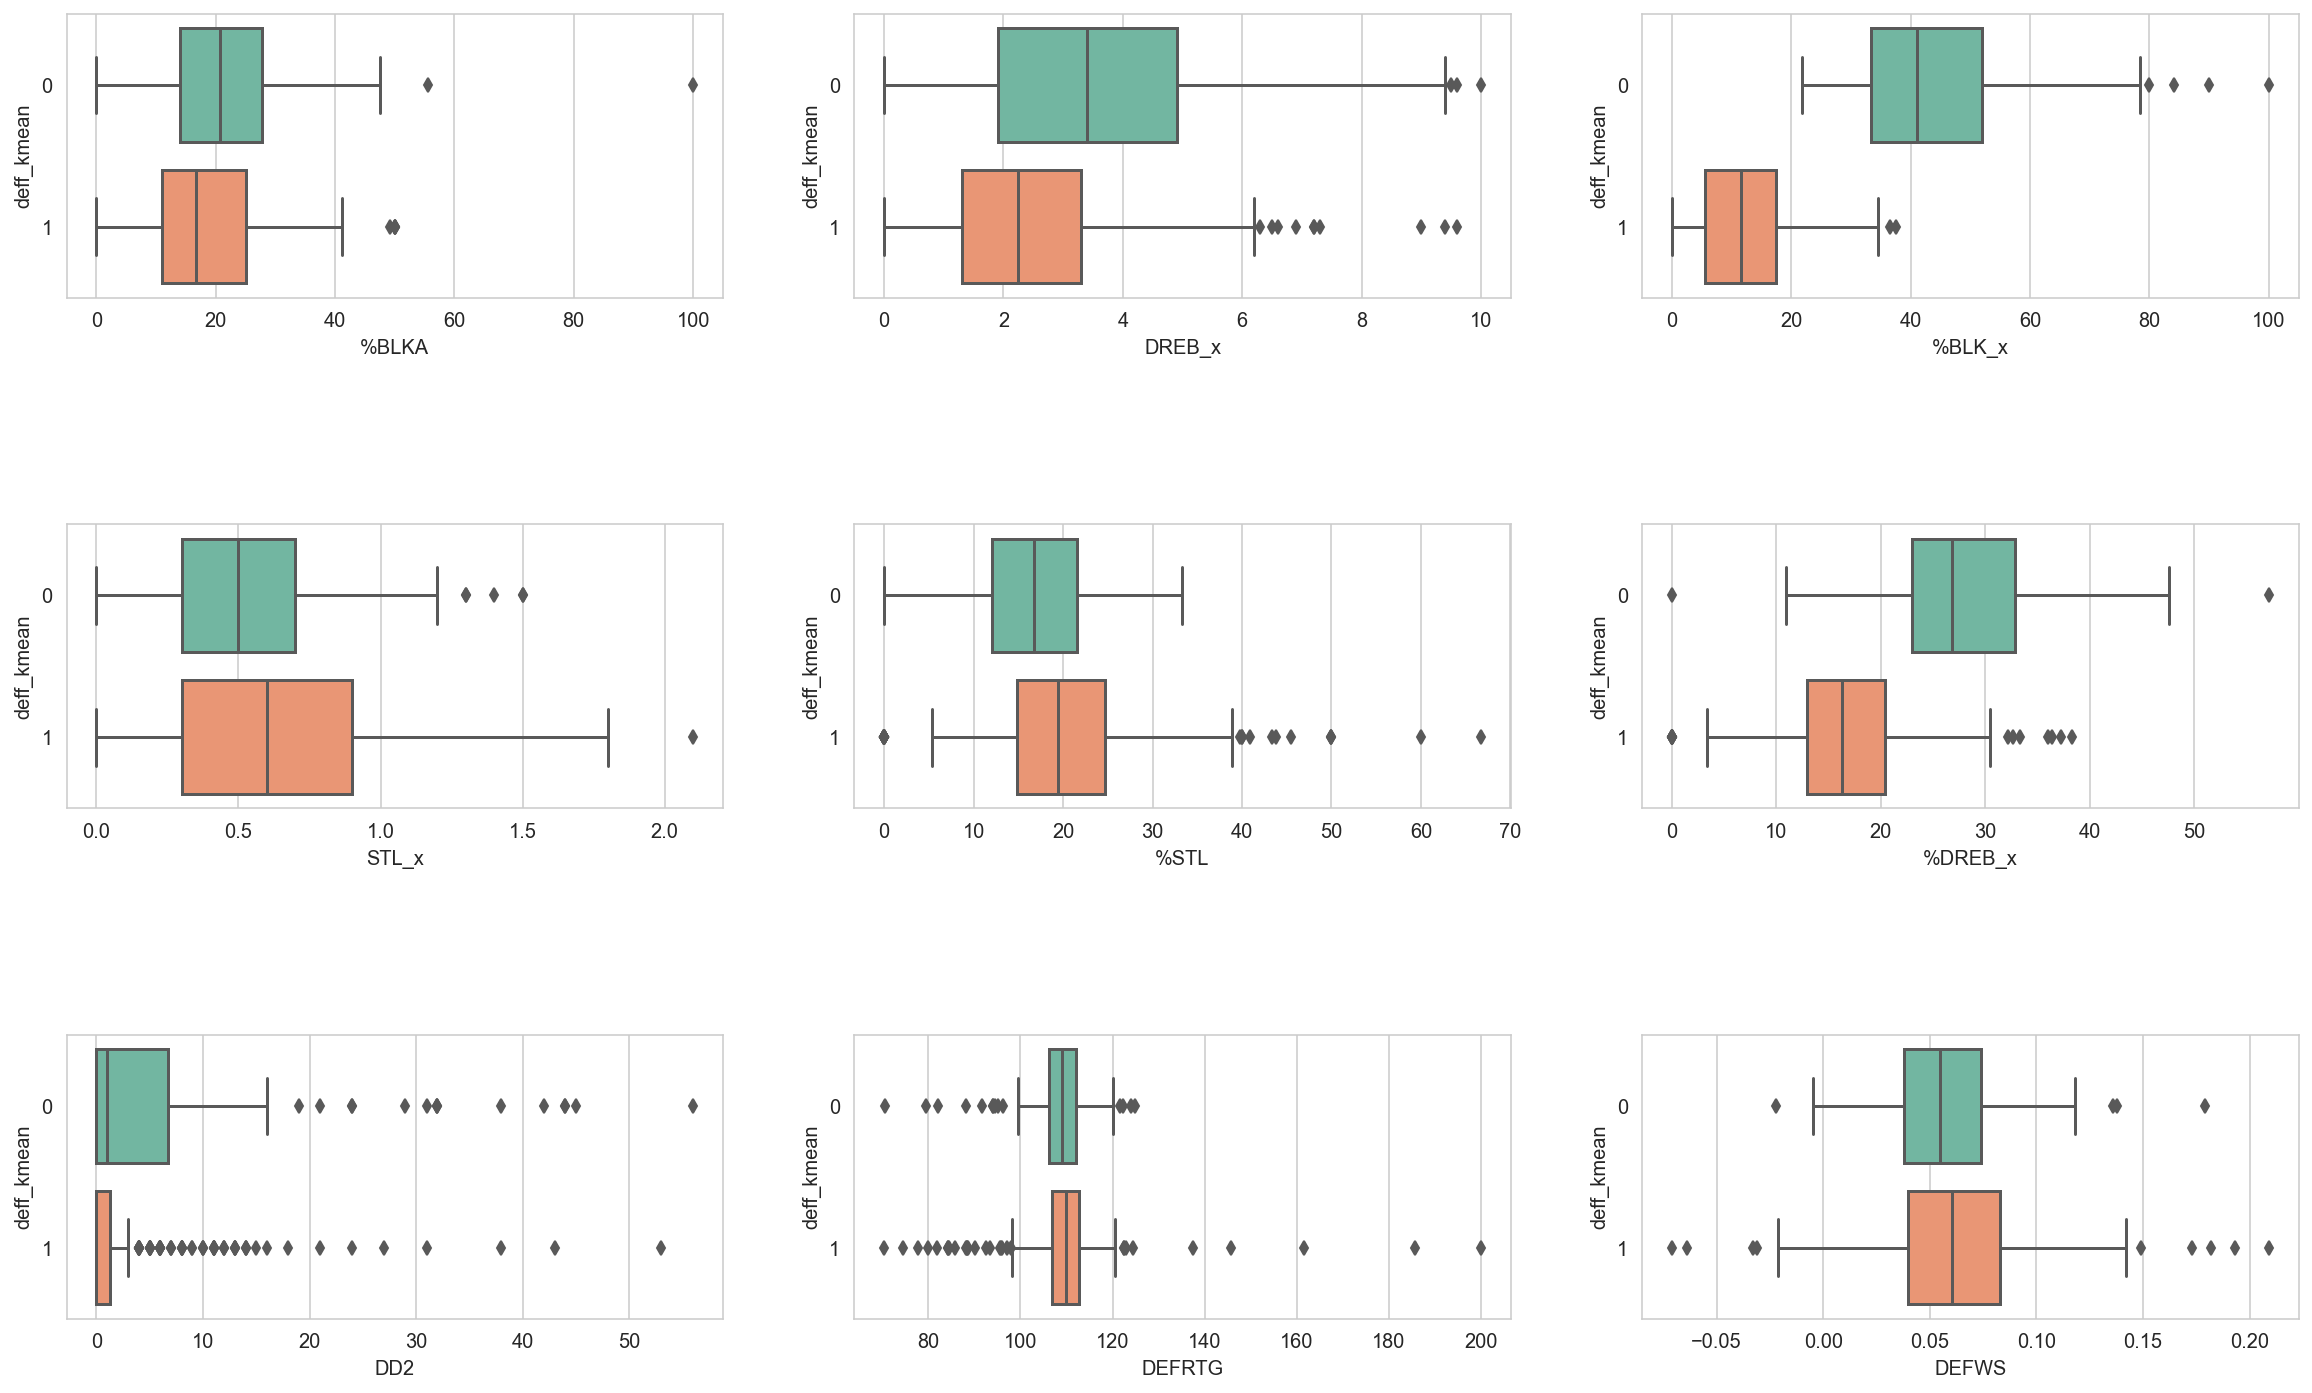

In [28]:
fig, axes = plt.subplots(3, 3, figsize = (20, 12))
plt.subplots_adjust(hspace = 0.8)

# How well a player protects the paint and how well a player plays help defense
sns.boxplot(x = '%BLKA', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[0,0])
sns.boxplot(x = 'DREB_x', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[0,1])
sns.boxplot(x = '%BLK_x', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[0,2])
#---------------------- line 2
# How well a player scores 2 pointers
sns.boxplot(x = 'STL_x', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[1,0])
sns.boxplot(x = '%STL', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[1,1])
sns.boxplot(x = '%DREB_x', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[1,2])
#----------------------
sns.boxplot(x = 'DD2', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[2,0])
sns.boxplot(x = 'DEFRTG', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[2,1])
sns.boxplot(x = 'DEFWS', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2", ax = axes[2,2]);


## ```Recommender Dataframes```
---

In [11]:
from sklearn.metrics import pairwise_distances
import pickle
from scipy import sparse

In [12]:
# Creating Pivot table
deff_piv = pd.pivot_table(nba_stats2021[def_stat], index = nba_stats2021['Player'])

# Create sparse matrix
deff_sparse = sparse.csr_matrix(deff_piv.fillna(0))

# Calculating Cosine similarity
deff_recommend = pairwise_distances(deff_sparse, metric='cosine')

# Creating Recommender Dataframe
deff_rec_df = pd.DataFrame(deff_recommend, columns=deff_piv.index, index = deff_piv.index)

In [13]:
pickle.dump(deff_rec_df, open('pickle models/def_stat.p', 'wb'))

In [14]:
players = deff_rec_df['LeBron James'].sort_values()[1:4].index
players

Index(['Luka Doncic', 'Jayson Tatum', 'Bobby Portis'], dtype='object', name='Player')

## ```Modern Player Reclassification```
---

In [17]:
deff_cluster0.sort_values(by='PTS', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%OREB,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,deff_kmean
2,Joel Embiid,PHI,27,47,36,11,31.5,29.1,9.2,18.0,...,43.3,37.2,18.4,34.7,16.1,35.0,21.5,53.0,37.1,0
5,Giannis Antetokounmpo,MIL,26,56,36,20,33.1,28.4,10.3,18.3,...,24.9,33.5,33.2,37.3,21.1,35.1,23.3,55.8,34.0,0
6,Kevin Durant,BKN,32,29,18,11,33.1,28.3,9.8,17.9,...,6.9,22.2,26.6,35.2,17.1,25.5,16.4,39.0,32.5,0
12,Nikola Jokic,DEN,26,66,44,22,35.0,26.4,10.2,18.1,...,38.1,34.3,41.0,33.9,24.6,27.9,21.8,40.2,30.9,0
19,Karl-Anthony Towns,MIN,25,44,16,28,34.1,24.8,8.5,17.5,...,36.5,35.3,23.6,32.2,12.8,28.2,25.3,39.7,30.2,0


In [29]:
deff_cluster0['%DREB_x'].mean()

27.60869565217391

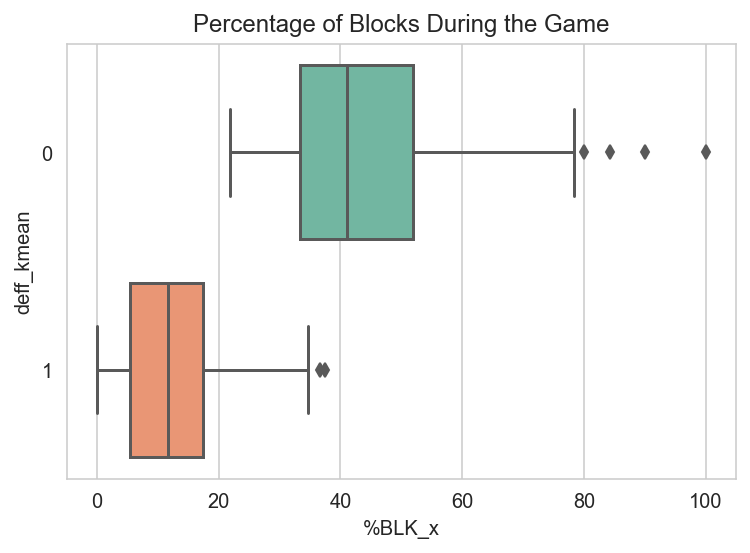

In [32]:
plt.title('Percentage of Blocks During the Game')
sns.boxplot(x = '%BLK_x', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2");

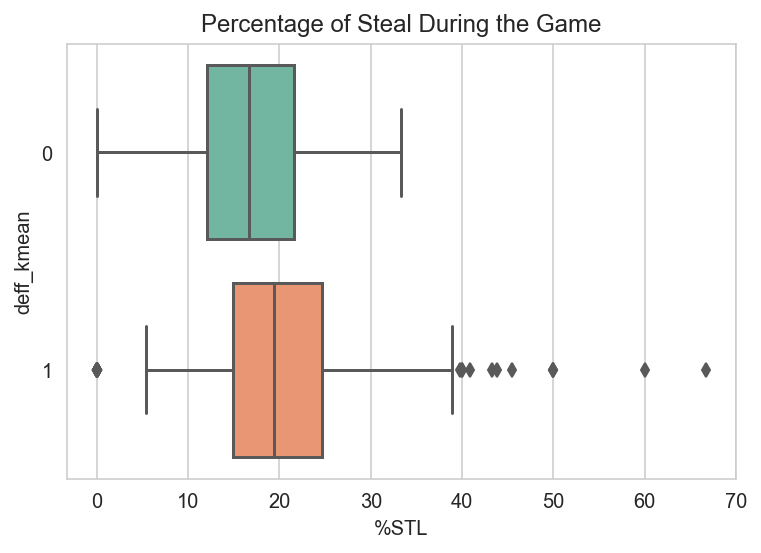

In [33]:
plt.title('Percentage of Steal During the Game')
sns.boxplot(x = '%STL', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2");

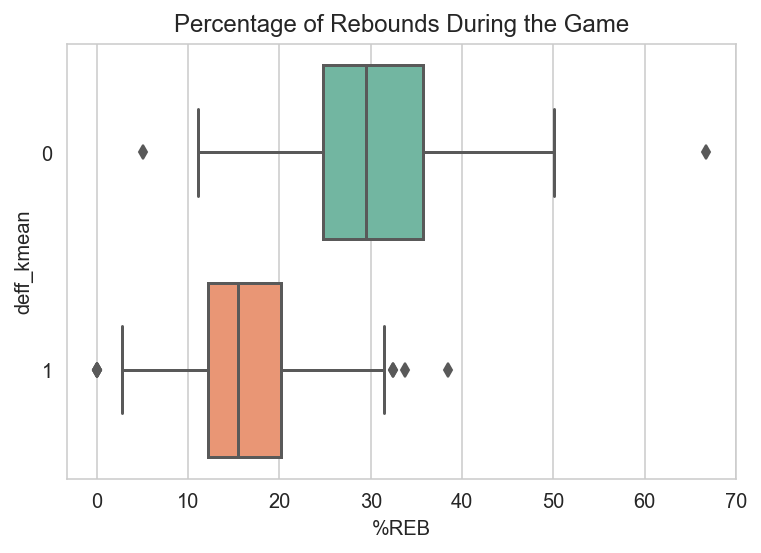

In [34]:
plt.title('Percentage of Rebounds During the Game')
sns.boxplot(x = '%REB', y = 'deff_kmean', data = nba_stats2021, orient="h", palette="Set2");

In [18]:
deff_cluster1.sort_values(by='PTS', ascending=False).head()

,Player,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,%OREB,%REB,%AST,%TOV,%STL,%BLKA,%PF,%PFD,%PTS,deff_kmean
0,Stephen Curry,GSW,33,58,32,26,34.1,31.5,10.3,21.3,...,8.0,17.9,27.6,29.8,20.8,32.5,12.1,32.1,37.1,1
1,Bradley Beal,WAS,27,57,29,28,35.6,31.1,11.1,22.8,...,15.9,14.3,22.9,29.6,20.1,26.5,14.3,32.3,34.9,1
3,Luka Doncic,DAL,22,59,35,24,35.1,28.5,10.1,20.8,...,12.5,25.6,52.4,49.9,21.3,32.2,16.8,38.5,33.7,1
4,Damian Lillard,POR,30,61,34,27,35.7,28.4,8.8,20.0,...,6.0,12.8,46.2,36.6,18.0,29.1,11.5,43.1,32.0,1
7,Zach LaVine,CHI,26,53,22,31,35.2,27.5,9.8,19.4,...,9.1,15.7,25.7,32.1,17.0,31.3,17.5,30.3,32.6,1


In [31]:
deff_cluster1['%STL'].mean()

20.01767676767679